In [1]:
%pip install equinox

Note: you may need to restart the kernel to use updated packages.


In [2]:
import equinox as eqx
import jax
import jax.numpy as jnp

class SurrogateModel(eqx.Module):
    
    layers: list
        
    def __init__(self, in_size, out_size, width_size, depth, activation, key):
        keys = jax.random.split(key, depth + 2)
        
        input_key = keys[0]
        output_key = keys[-1]
        hidden_keys = keys[1:-1]
        
        input_layer = eqx.nn.Linear(in_size, width_size, key=input_key)
        output_layer = eqx.nn.Linear(width_size, out_size, key=output_key)
        
        #Make Reynolds number on log10 scale
        @jax.jit
        def normalize_reynolds_number(x):
            Re = x[-1]
            Re = jnp.log10(Re)
            
            #Set maximum of Re=10^6
            Re = jnp.min(jnp.hstack((Re, 6)))
            
            return jnp.hstack((x[:-1], Re))
            
        
        self.layers = [
            normalize_reynolds_number,
            jax.nn.standardize, #Standardize -1 to 1
            input_layer,
            activation
        ]
        for key in hidden_keys:
            self.layers.append(eqx.nn.Linear(width_size, width_size, key=key))
            self.layers.append(activation)
            
        self.layers.append(output_layer)
        
    def __call__(self, x):
                
        for layer in self.layers:
            x = layer(x)

        return x

#Create dummy model
key = jax.random.PRNGKey(42)
model = SurrogateModel(
    in_size=8,
    out_size=1,
    width_size=64,
    depth=4,
    activation=jax.nn.silu,
    key=key
)
model = eqx.tree_deserialise_leaves(f"models/lift_surrogate.eqx", model)

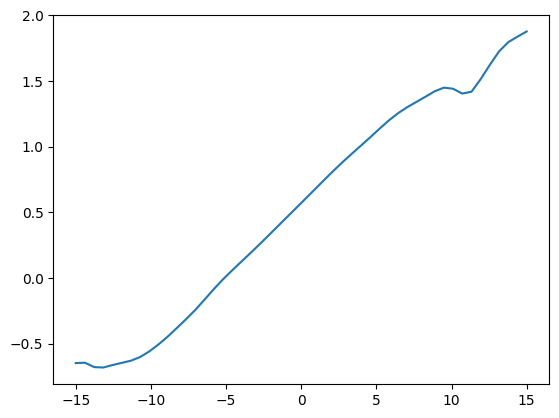

In [3]:
import matplotlib.pyplot as plt

B = 1.79094660282135
T = 0.1879087835550308
P = 2.998518228530884
C = 0.0500964857637882
E = 0.9923266768455504
R = 0.0028237155638635
Re = 1_000_000

thetas = jnp.linspace(-15, 15, 50)

def cl(B, T, P, C, E, R, alpha, Re):
    return model(jnp.array([B, T, P, C, E, R, alpha, Re]))

cl = jax.vmap(cl, in_axes=(None, None, None, None, None, None, 0, None))

lifts = cl(B, T, P, C, E, R, thetas, Re)

plt.plot(thetas, lifts)